In [1]:
%matplotlib inline

## Intro

Este tutorial é baseado no tutorial [Atenção é tudo que você precisa](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

O transformador descrito no artigo `Attention is All You Need` tem sido de grande interesse para vários pesquisadores em redes neurais. Além de produzir ganhos significativos em tarefas de tradução, este modelo provê uma nova arquitetura para muitas tarefas de processamento de linguagem natural (`NLP`).

O artigo é extremamente bem escrito, mas é de conhecimento comum que esta arquitetura é bastante difícil de implementar de forma correta. Sendo assim, Alexander Rush escreveu esta versão linha-a-linha de como o modelo é implementado. Ele também teve ajuda de Vincent Nguyen e Guilherme Klein.

De toda forma, eu espero que eu possa capturar de forma correta os argumentos/ideias descritas no artigo e explanadas pelos pesquisadores citados acima.

### Dependências

* torchtext
* spacy
* seaborn
* torchtext
* matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

## Contexto

Intra-atenção (`self-attention`) é um mecanismo de atenção que relaciona diferentes posições de uma única sequência de modo a computar a representação daquela sequência. Intra-antenção foi utilizado com sucesso em uma variedade de tarefas cujos nomes eu não me arrisco a traduzir (reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations).

Redes neurais nesta arquitetura são baseadas em atenção recorrente ao invés de alinhamentos sequenciais e foi comprovado que esta arquitetura performa bem em tarefas de perguntas e respostas ou na representação de modelos de linguage. 

# Arquitetura

Assim como a maioria dos modelos de sequência mais robustos, a arquiterura deste modelo segue a estrutura de um codificador-decodificador. 

Aqui, o codificador mapeia uma sequência de entrada com símbolos ($x_1, ..., x_n$) para uma sequência de representação continua z = ($z_1, ..., z_n$). 

Dado z, o decodificador gera então uma sequência de símbolos de saída ($y_1, ..., y_n$) - um símbolo a cada intervalo de tempo. A cada intervalo de tempo, o modelo é auto-regressivo, consumindo a última sequência de símbolos como parte da entrada.

In [6]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [7]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

O transformador segue esta arquitetura empilhando uma série de camadas de intra-atenção, além de camadas densamente conectadas tanto no codificador quanto no decodificador, conforme exibidor no lado esquerdo e lado direito inferior da figura:

![alt text](images/ModalNet-21.png "Title")

`mais detalhes explicando a figura em breve....`

# Pilha de Codificadores e Decodificadores 

## Codificador

O codificador é composto de uma pilha de $N = 6$ camadas idênticas

In [3]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [4]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Aplicamos uma camada residual a cada duas camadas, e em seguida, utilizamos uma camada de normalização:

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

Em outras palavras, a saída de cada uma dessas camadas é uma $CamadaNormalizacao(x + SubCamada(x))$, onde $SubCamada(x)$ é a função implementada pela sub-camada. Também aplicamos dropout na saída de cada sub-camada antes de adicionarmos e normalizarmos os valores de entrada.

Para facilitar a conexão entre estas camadas, todas as sub-camadas do modelo assim como as camadas intermediárias produzem saídas cujas dimensões são $d_{model} = 512$

In [5]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Cada camada possui duas sub-camadas. A primeira, implementa um mecanismo de intra-atenção múltipla enquanto que a segunda camada implementa um algoritmo de feed-forward posicional

In [6]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decodificador

O decodificador também é composto de uma pilha de $N = 6$ camadas idênticas

In [7]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

Em adição as duas sub-camadas existentes no codificador, o decodificador também possui uma terceira sub-camada, que computa atenção múltipla na saída da pilha de codificadores. De forma similar ao codificador, também utilizamos conexões residuais em cada subcamada, seguidas por uma camada de normalização.

In [8]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Também é necessário que modifiquemos a camada de intra-atenção na pilha de decodificadores para previnir que uma determinada posição atenda à posições subsequentes. Esta modificação introduz um mecanismo de obfuscação (ou máscara) que combinado com o fato dos vetores estarem deslocados uma posição para a direita assegura que as predições na posição $i$ dependerão só e somente de saídas menores que $i$

In [9]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

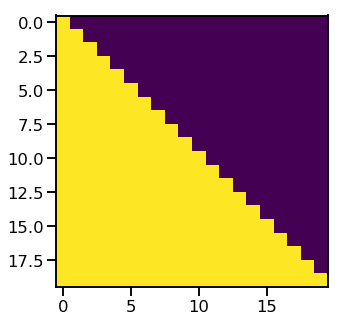

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

# Atenção

Uma função de atenção pode ser descrita como uma função que mapeia um consulta (`Q`) e um conjunto de chaves e valores (`K` e `V `) onde a consulta, chaves e valores assim como a saída da função são todos vetores. A saída é computada como uma soma ponderada dos valores, onde os pesos atribuídos a cada valor são computados através de uma função de compatibilidade entre a consulta e a sua correspondente chave.

Cada mecanismo individual de atenção é chamado de **atenção de produto escalar** (`Scaled Dot-Product Attention`).
Os dados de entrada consistem de uma consulta e chaves de dimensão $d_K$ e valores de dimensão $d_v$. Nos executamos o produto de cada termo da consulta com cada chave, dividindo cada um por $\sqrt{d_K}$ e aplicando softmax para obter os pesos de cada valor computado.

![alt text](images/attention.png "Title")

___
**nota pessoal:** 

Há muita confusão quanto aos valores que `Q`, `K` e `V` podem assumir. No grupo de discussões de redes neurais, o aluno que explicou da seguinte forma:


`TODO`

___

Na prática, computamos a função de atenção em um conjunto de consultas simultaneamente. As consultas são agrupadas em uma matriz `Q` assim como as chaves e valores são agrupados em matrizes `K` e `V`. As matrizes de saída são computadas como:

\begin{equation}
    Attention(Q, K, V) = softmax\Big(\frac{QK^T}{\sqrt{d_k}}\Big)V
\end{equation}

In [12]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k) # primeira caixa roxa (baixo para cima)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1) # caixa verde na figura
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn 

# são retornados dois valores, o primeiro é o resultado da função de anteção (multiplicação de matrizes)
# o segundo é são os vetores de atenção, obtidos após o softmax.
# TODO: indicar onde o vetor de atenção é utilizado em etapas posteriores do notebook

As duas funções mais comuns de atenção são atenção-aditiva e atenção-produto-escalar. A atenção por produto escalar é idêntica ao algoritmo acima exceto por um fator escalar (caixa amarela na imagem?) de $\frac{1}{\sqrt{d_k}}$. 

Apesar de teoricamente serem semelhantes, a atenção por produto escalar é mais rápida uma vez que ela pode se beneficiar de códigos que optimizam a multiplicação de matrizes. No entanto, há cenários onde a atenção aditiva é superior. Para uma discussão mais detalhada, direcionamos o leitor ao artigo original.